In [82]:
import numpy as np
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt

import sympy as smp
import scipy as sc

from numba import jit

plt.style.use(['science', 'grid'])

In [83]:
mu0 = 4*np.pi*1e-7
radius = 25e-3
nb_spire_dist = {
    5: 10.3e-3,
    10: 20.6e-3,
    20: 40.3e-3,
    30: 60.9e-3,
    50: 101.2e-3,
    70: 141.6e-3,
    100: 202.5e-3
}

spire_dist = pd.DataFrame(list(nb_spire_dist.items()), columns=['nb_spire', 'dist'])
spire_dist

,nb_spire,dist
0,5,0.0103
1,10,0.0206
2,20,0.0403
3,30,0.0609
4,50,0.1012
5,70,0.1416
6,100,0.2025


In [84]:
spire_dist_render = spire_dist.copy()

spire_dist_render['dist'] = spire_dist_render['dist'].apply(lambda x: x*1e3)

print(spire_dist_render.to_latex(index=False))

\begin{tabular}{rr}
\toprule
 nb\_spire &  dist \\
\midrule
        5 &  10.3 \\
       10 &  20.6 \\
       20 &  40.3 \\
       30 &  60.9 \\
       50 & 101.2 \\
       70 & 141.6 \\
      100 & 202.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4336/4197332644.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(spire_dist_render.to_latex(index=False))


# Expérience 1

In [85]:
mesures_exp_1 = {
    5: 1.13e-3,
    10: 1.9e-3,
    20: 2.57e-3,
    30: 2.81e-3,
    50: 2.95e-3,
    70: 3e-3,
    100: 3.02e-3
}

exp_1 = pd.DataFrame(list(mesures_exp_1.items()), columns=['nb_spire', 'B'])
exp_1['dist'] = spire_dist['dist']

exp_1

,nb_spire,B,dist
0,5,0.00113,0.0103
1,10,0.00190,0.0206
2,20,0.00257,0.0403
3,30,0.00281,0.0609
4,50,0.00295,0.1012
5,70,0.00300,0.1416
6,100,0.00302,0.2025


Approximation par la loi d'Ampère :

$$ B = \frac{N I \mu_0}{l} $$

In [86]:
@jit(nopython=True)
def B_approx(I, N, L):
    return mu0*N*I/L

In [87]:
exp_1['B_theo_approx'] = B_approx(5, exp_1['nb_spire'].to_numpy(), exp_1['dist'].to_numpy())
exp_1

,nb_spire,B,dist,B_theo_approx
0,5,0.00113,0.0103,0.003050
1,10,0.00190,0.0206,0.003050
2,20,0.00257,0.0403,0.003118
3,30,0.00281,0.0609,0.003095
4,50,0.00295,0.1012,0.003104
5,70,0.00300,0.1416,0.003106
6,100,0.00302,0.2025,0.003103


Par un résultat analytique :

$$ B = \frac{N I \mu_0}{l} \frac{\cos \theta_1 + \cos \theta_1}{2} $$

In [88]:
@jit(nopython=True)
def B_anal(I, N, L, r, x=0.):
    return mu0*N*I/L * (np.cos(np.arctan2(r, L+x)) + np.cos(np.arctan2(r, L-x)))/2

In [89]:
exp_1['B_theo_anal'] = B_anal(5, exp_1['nb_spire'].to_numpy(), exp_1['dist'].to_numpy(), radius)
exp_1

,nb_spire,B,dist,B_theo_approx,B_theo_anal
0,5,0.00113,0.0103,0.003050,0.001162
1,10,0.00190,0.0206,0.003050,0.001940
2,20,0.00257,0.0403,0.003118,0.002650
3,30,0.00281,0.0609,0.003095,0.002863
4,50,0.00295,0.1012,0.003104,0.003014
5,70,0.00300,0.1416,0.003106,0.003059
6,100,0.00302,0.2025,0.003103,0.003079


In [90]:
exp_1['delta_abs_approx'] = np.abs(exp_1['B'] - exp_1['B_theo_approx'])
exp_1['delta_abs_anal'] = np.abs(exp_1['B'] - exp_1['B_theo_anal'])

exp_1['delta_rel_approx'] = exp_1['delta_abs_approx']/exp_1['B']
exp_1['delta_rel_anal'] = exp_1['delta_abs_anal']/exp_1['B']

exp_1

,nb_spire,B,dist,B_theo_approx,B_theo_anal,delta_abs_approx,delta_abs_anal,delta_rel_approx,delta_rel_anal
0,5,0.00113,0.0103,0.003050,0.001162,0.001920,0.000032,1.699195,0.028220
1,10,0.00190,0.0206,0.003050,0.001940,0.001150,0.000040,0.605311,0.020855
2,20,0.00257,0.0403,0.003118,0.002650,0.000548,0.000080,0.213310,0.031035
3,30,0.00281,0.0609,0.003095,0.002863,0.000285,0.000053,0.101482,0.018966
4,50,0.00295,0.1012,0.003104,0.003014,0.000154,0.000064,0.052319,0.021608
5,70,0.00300,0.1416,0.003106,0.003059,0.000106,0.000059,0.035365,0.019596
6,100,0.00302,0.2025,0.003103,0.003079,0.000083,0.000059,0.027420,0.019678


In [91]:
exp1_render = exp_1[['nb_spire', 'B', 'B_theo_approx', 'delta_abs_approx', 'delta_rel_approx', 'B_theo_anal', 'delta_abs_anal', 'delta_rel_anal']]

for c in ['B', 'B_theo_approx', 'B_theo_anal', 'delta_abs_approx', 'delta_abs_anal'] :
    exp1_render[c] = exp1_render[c].apply(lambda x: np.round(x*1e3, 3))

for c in ['delta_rel_approx', 'delta_rel_anal'] :
    exp1_render[c] = exp1_render[c].apply(lambda x: np.round(x*100, 2))    

print(exp1_render.to_latex(index=False))

\begin{tabular}{rrrrrrrr}
\toprule
 nb\_spire &    B &  B\_theo\_approx &  delta\_abs\_approx &  delta\_rel\_approx &  B\_theo\_anal &  delta\_abs\_anal &  delta\_rel\_anal \\
\midrule
        5 & 1.13 &          3.050 &             1.920 &            169.92 &        1.162 &           0.032 &            2.82 \\
       10 & 1.90 &          3.050 &             1.150 &             60.53 &        1.940 &           0.040 &            2.09 \\
       20 & 2.57 &          3.118 &             0.548 &             21.33 &        2.650 &           0.080 &            3.10 \\
       30 & 2.81 &          3.095 &             0.285 &             10.15 &        2.863 &           0.053 &            1.90 \\
       50 & 2.95 &          3.104 &             0.154 &              5.23 &        3.014 &           0.064 &            2.16 \\
       70 & 3.00 &          3.106 &             0.106 &              3.54 &        3.059 &           0.059 &            1.96 \\
      100 & 3.02 &          3.103 &            

/tmp/ipykernel_4336/3184976659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp1_render[c] = exp1_render[c].apply(lambda x: np.round(x*1e3, 3))
/tmp/ipykernel_4336/3184976659.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp1_render[c] = exp1_render[c].apply(lambda x: np.round(x*100, 2))
/tmp/ipykernel_4336/3184976659.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signat

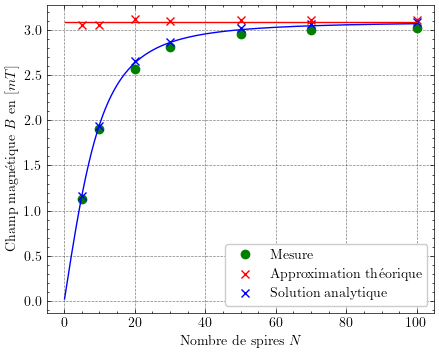

In [92]:
# plot the magnetic field as a function of the number of spires
# all the legend are in french, displaying the latex code for the symbols
# make a curve for the theoretical approximation and the analytical solution
# for the points, display them as crosses
t = np.linspace(0, 100, 1000)
rapp_dist = np.mean([nb_spire_dist[i]/i for i in nb_spire_dist.keys()])

plt.figure(figsize=(5, 4))
plt.plot(exp_1['nb_spire'], exp_1['B'].apply(lambda x: x*1000), 'o', label='Mesure', color='green')
plt.plot(exp_1['nb_spire'], exp_1['B_theo_approx'].apply(lambda x: x*1000), 'x', label='Approximation théorique', color='red')
plt.plot(exp_1['nb_spire'], exp_1['B_theo_anal'].apply(lambda x: x*1000), 'x', label='Solution analytique', color='blue')

plt.plot(t, B_approx(5, t, rapp_dist*t)*1000, color='red')
plt.plot(t, B_anal(5, t, rapp_dist*t, radius)*1000, color='blue')

plt.xlabel(r'Nombre de spires $N$')
plt.ylabel(r'Champ magnétique $B$ en $[mT]$')
plt.legend()

plt.savefig('solenoide_1.pdf')
plt.show()

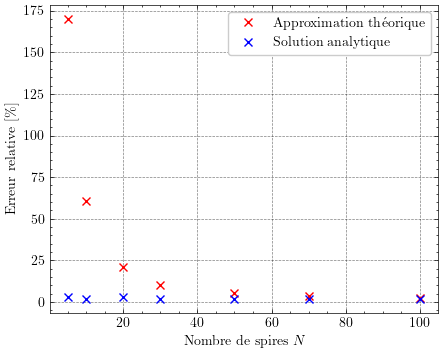

In [93]:
# plot the relative error as a function of the number of spires
plt.figure(figsize=(5, 4))
plt.plot(exp_1['nb_spire'], exp_1['delta_rel_approx'].apply(lambda x: x*100), 'x', label='Approximation théorique', color='red')
plt.plot(exp_1['nb_spire'], exp_1['delta_rel_anal'].apply(lambda x: x*100), 'x', label='Solution analytique', color='blue')

plt.xlabel(r'Nombre de spires $N$')
plt.ylabel(r'Erreur relative $[\%]$')
plt.legend()

plt.savefig('solenoide_2.pdf')
plt.show()

# Expérience 2

In [94]:
mesures_exp_2 = {
    20: [[i*1e-2 for i in range(21)], [i*1e-3 for i in [2.58,2.57,2.44,2.15,1.66,1.07,0.63,0.38,0.24,0.16,0.11,0.09,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.03,0.02]]],
    50: [[i*1e-2 for i in range(24)], [i*1e-3 for i in [2.97,2.97,2.96,2.95,2.93,2.9,2.85,2.76,2.58,2.28,1.8,1.2,0.72,0.44,0.3,0.21,0.15,0.12,0.1,0.08,0.07,0.07,0.06,0.06]]],
    100: [[i*1e-2 for i in range(27)], [i*1e-3 for i in [3,3,3,3,3.01,3.01,3.01,3.01,3.01,3.01,3,3,3,2.98,2.96,2.92,2.86,2.77,2.62,2.36,1.89,1.28,0.78,0.46,0.3,0.2,0.16]]]
    }

exp_2_20 = pd.DataFrame({'dist': mesures_exp_2[20][0], 'B': mesures_exp_2[20][1]})
exp_2_50 = pd.DataFrame({'dist': mesures_exp_2[50][0], 'B': mesures_exp_2[50][1]})
exp_2_100 = pd.DataFrame({'dist': mesures_exp_2[100][0], 'B': mesures_exp_2[100][1]})
exp_2_20, exp_2_50, exp_2_100

(    dist        B
 0   0.00  0.00258
 1   0.01  0.00257
 2   0.02  0.00244
 3   0.03  0.00215
 4   0.04  0.00166
 5   0.05  0.00107
 6   0.06  0.00063
 7   0.07  0.00038
 8   0.08  0.00024
 9   0.09  0.00016
 10  0.10  0.00011
 11  0.11  0.00009
 12  0.12  0.00006
 13  0.13  0.00005
 14  0.14  0.00004
 15  0.15  0.00004
 16  0.16  0.00003
 17  0.17  0.00003
 18  0.18  0.00003
 19  0.19  0.00003
 20  0.20  0.00002,
     dist        B
 0   0.00  0.00297
 1   0.01  0.00297
 2   0.02  0.00296
 3   0.03  0.00295
 4   0.04  0.00293
 5   0.05  0.00290
 6   0.06  0.00285
 7   0.07  0.00276
 8   0.08  0.00258
 9   0.09  0.00228
 10  0.10  0.00180
 11  0.11  0.00120
 12  0.12  0.00072
 13  0.13  0.00044
 14  0.14  0.00030
 15  0.15  0.00021
 16  0.16  0.00015
 17  0.17  0.00012
 18  0.18  0.00010
 19  0.19  0.00008
 20  0.20  0.00007
 21  0.21  0.00007
 22  0.22  0.00006
 23  0.23  0.00006,
     dist        B
 0   0.00  0.00300
 1   0.01  0.00300
 2   0.02  0.00300
 3   0.03  0.00300
 4   0.04 

Comparaison avec la formule analytique

In [95]:
exp_2_20['B_theo_anal'] = B_anal(5, 20, nb_spire_dist[20], radius, exp_2_20['dist'].to_numpy())
exp_2_20

,dist,B,B_theo_anal
0,0.00,0.00258,0.002650
1,0.01,0.00257,0.002599
2,0.02,0.00244,0.002423
3,0.03,0.00215,0.002063
4,0.04,0.00166,0.001507
5,0.05,0.00107,0.000939
6,0.06,0.00063,0.000548
7,0.07,0.00038,0.000328
8,0.08,0.00024,0.000207
9,0.09,0.00016,0.000138


In [96]:
exp_2_50['B_theo_anal'] = B_anal(5, 50, nb_spire_dist[50], radius, exp_2_50['dist'].to_numpy())
exp_2_50

,dist,B,B_theo_anal
0,0.00,0.00297,0.003014
1,0.01,0.00297,0.003011
2,0.02,0.00296,0.003004
3,0.03,0.00295,0.002989
4,0.04,0.00293,0.002965
5,0.05,0.00290,0.002926
6,0.06,0.00285,0.002861
7,0.07,0.00276,0.002747
8,0.08,0.00258,0.002541
9,0.09,0.00228,0.002174


In [97]:
exp_2_100['B_theo_anal'] = B_anal(5, 100, nb_spire_dist[100], radius, exp_2_100['dist'].to_numpy())
exp_2_100

,dist,B,B_theo_anal
0,0.00,0.00300,0.003079
1,0.01,0.00300,0.003079
2,0.02,0.00300,0.003079
3,0.03,0.00300,0.003078
4,0.04,0.00301,0.003077
5,0.05,0.00301,0.003075
6,0.06,0.00301,0.003072
7,0.07,0.00301,0.003069
8,0.08,0.00301,0.003065
9,0.09,0.00301,0.003060


In [98]:
exp_2_20['delta_abs_anal'] = np.abs(exp_2_20['B'] - exp_2_20['B_theo_anal'])
exp_2_20['delta_rel_anal'] = exp_2_20['delta_abs_anal']/exp_2_20['B']

exp_2_50['delta_abs_anal'] = np.abs(exp_2_50['B'] - exp_2_50['B_theo_anal'])
exp_2_50['delta_rel_anal'] = exp_2_50['delta_abs_anal']/exp_2_50['B']

exp_2_100['delta_abs_anal'] = np.abs(exp_2_100['B'] - exp_2_100['B_theo_anal'])
exp_2_100['delta_rel_anal'] = exp_2_100['delta_abs_anal']/exp_2_100['B']

exp_2_20, exp_2_50, exp_2_100

(    dist        B  B_theo_anal  delta_abs_anal  delta_rel_anal
 0   0.00  0.00258     0.002650        0.000070        0.027039
 1   0.01  0.00257     0.002599        0.000029        0.011194
 2   0.02  0.00244     0.002423        0.000017        0.006957
 3   0.03  0.00215     0.002063        0.000087        0.040512
 4   0.04  0.00166     0.001507        0.000153        0.091967
 5   0.05  0.00107     0.000939        0.000131        0.122792
 6   0.06  0.00063     0.000548        0.000082        0.130411
 7   0.07  0.00038     0.000328        0.000052        0.137495
 8   0.08  0.00024     0.000207        0.000033        0.136747
 9   0.09  0.00016     0.000138        0.000022        0.135274
 10  0.10  0.00011     0.000097        0.000013        0.119776
 11  0.11  0.00009     0.000070        0.000020        0.217601
 12  0.12  0.00006     0.000053        0.000007        0.119206
 13  0.13  0.00005     0.000041        0.000009        0.185860
 14  0.14  0.00004     0.000032        0

In [99]:
exp_2_20_copy = exp_2_20.copy()
exp_2_50_copy = exp_2_50.copy()
exp_2_100_copy = exp_2_100.copy()

for df in [exp_2_20_copy, exp_2_50_copy, exp_2_100_copy]:
    df['delta_rel_anal'] = df['delta_rel_anal'].apply(lambda x: np.round(x*100, 2))

    df['dist'] = df['dist'].apply(lambda x: np.round(x*1e2, 0))

    for c in ['B', 'B_theo_anal', 'delta_abs_anal']:
        df[c] = df[c].apply(lambda x: np.round(x*1e3, 3))

exp2_render = pd.concat(dict(exp_20 = exp_2_20_copy, exp_50 = exp_2_50_copy, exp_100 = exp_2_100_copy), axis=1)  
exp2_render = exp2_render.fillna('')

exp2_render_tex = exp2_render.to_latex(index=True)
n_rows, n_cols = exp2_render.shape
exp2_render = exp2_render.set_index([[""] * n_rows])
exp2_render_tex = exp2_render.to_latex(index=True, escape=False, column_format="r" * n_cols)
exp2_render_tex = exp2_render_tex.replace("{} &", "")
print(exp2_render_tex)

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
 \multicolumn{5}{l}{exp_20} & \multicolumn{5}{l}{exp_50} & \multicolumn{5}{l}{exp_100} \\
   dist &     B & B_theo_anal & delta_abs_anal & delta_rel_anal &   dist &     B & B_theo_anal & delta_abs_anal & delta_rel_anal &    dist &     B & B_theo_anal & delta_abs_anal & delta_rel_anal \\
\midrule
    0.0 &  2.58 &        2.65 &           0.07 &            2.7 &    0.0 &  2.97 &       3.014 &          0.044 &           1.47 &     0.0 &  3.00 &       3.079 &          0.079 &           2.65 \\
    1.0 &  2.57 &       2.599 &          0.029 &           1.12 &    1.0 &  2.97 &       3.011 &          0.041 &           1.39 &     1.0 &  3.00 &       3.079 &          0.079 &           2.64 \\
    2.0 &  2.44 &       2.423 &          0.017 &            0.7 &    2.0 &  2.96 &       3.004 &          0.044 &           1.47 &     2.0 &  3.00 &       3.079 &          0.079 &           2.63 \\
    3.0 &  2.15 &       2.063 &          0.087 &           4.05 &  

/tmp/ipykernel_4336/1073409193.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  exp2_render_tex = exp2_render.to_latex(index=True)
/tmp/ipykernel_4336/1073409193.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  exp2_render_tex = exp2_render.to_latex(index=True, escape=False, column_format="r" * n_cols)


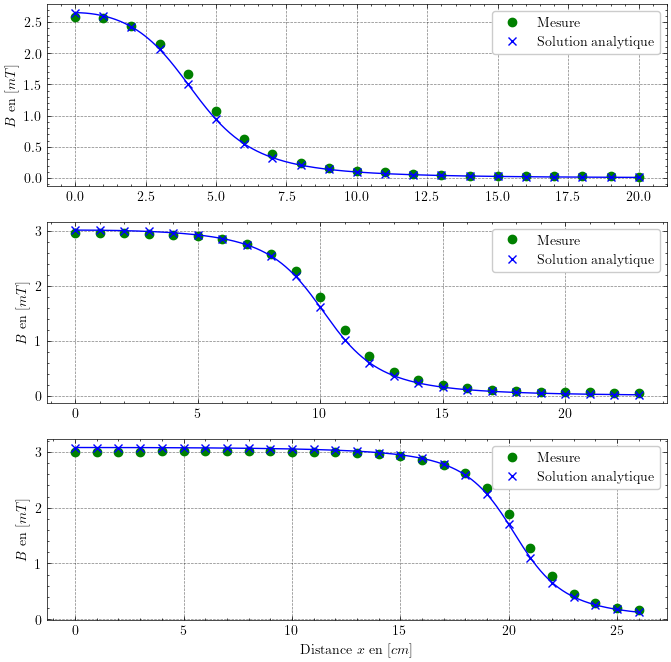

In [100]:
# plot the magnetic field as a function of the distance
# all the legend are in french, displaying the latex code for the symbols
# make a curve for the theoretical approximation and the analytical solution
# for the points, display them as crosses
# display each number of spires in a different subplot
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(exp_2_20['dist'].apply(lambda x: x*100), exp_2_20['B'].apply(lambda x: x*1000), 'o', label='Mesure', color='green')
plt.plot(exp_2_20['dist'].apply(lambda x: x*100), exp_2_20['B_theo_anal'].apply(lambda x: x*1000), 'x', label='Solution analytique', color='blue')

t20 = np.linspace(0, 0.2, 1000)
plt.plot(t20*100, B_anal(5, 20, nb_spire_dist[20], radius, t20)*1000, color='blue')

plt.ylabel(r'$B$ en $[mT]$')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(exp_2_50['dist'].apply(lambda x: x*100), exp_2_50['B'].apply(lambda x: x*1000), 'o', label='Mesure', color='green')
plt.plot(exp_2_50['dist'].apply(lambda x: x*100), exp_2_50['B_theo_anal'].apply(lambda x: x*1000), 'x', label='Solution analytique', color='blue')

t50 = np.linspace(0, 0.23, 1000)
plt.plot(t50*100, B_anal(5, 50, nb_spire_dist[50], radius, t50)*1000, color='blue')

plt.ylabel(r'$B$ en $[mT]$')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(exp_2_100['dist'].apply(lambda x: x*100), exp_2_100['B'].apply(lambda x: x*1000), 'o', label='Mesure', color='green')
plt.plot(exp_2_100['dist'].apply(lambda x: x*100), exp_2_100['B_theo_anal'].apply(lambda x: x*1000), 'x', label='Solution analytique', color='blue')

t100 = np.linspace(0, 0.26, 1000)
plt.plot(t100*100, B_anal(5, 100, nb_spire_dist[100], radius, t100)*1000, color='blue')

plt.xlabel(r'Distance $x$ en $[cm]$')
plt.ylabel(r'$B$ en $[mT]$')
plt.legend()

plt.savefig('solenoide_3.pdf')
plt.show()

# Simulation théorique

## Via sympy

Issue du [Document](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Tutorial%20Series/sympy1.ipynb)

In [101]:
x, y, z, t, I, mu0 = smp.symbols('x y z t I \mu_0', real=True)
f, g, h = smp.symbols('f g h', cls=smp.Function)
f=f(t)
g=g(t)
h=h(t)

In [102]:
r = smp.Matrix([x,y,z])
l = smp.Matrix([f,g,h])
dldt = smp.diff(l)

In [103]:
dBdt = I * dldt.cross(r-l) / (r-l).norm()**3

In [104]:
dBdt

Matrix([
[I*(-(y - g(t))*Derivative(h(t), t) + (z - h(t))*Derivative(g(t), t))/(Abs(x - f(t))**2 + Abs(y - g(t))**2 + Abs(z - h(t))**2)**(3/2)],
[ I*((x - f(t))*Derivative(h(t), t) - (z - h(t))*Derivative(f(t), t))/(Abs(x - f(t))**2 + Abs(y - g(t))**2 + Abs(z - h(t))**2)**(3/2)],
[I*(-(x - f(t))*Derivative(g(t), t) + (y - g(t))*Derivative(f(t), t))/(Abs(x - f(t))**2 + Abs(y - g(t))**2 + Abs(z - h(t))**2)**(3/2)]])

In [105]:
R, H = smp.symbols('R, H', real=True)

In [106]:
dBdt = dBdt.subs([(f, R*smp.cos(t)),
                  (g, R*smp.sin(t)),
                  (h, 0),
                  (x,0), (y,0), (z,H)]).doit()
dBdt.simplify()
dBdt

Matrix([
[H*I*R*cos(t)/(H**2 + R**2)**(3/2)],
[H*I*R*sin(t)/(H**2 + R**2)**(3/2)],
[      I*R**2/(H**2 + R**2)**(3/2)]])

In [107]:
mu0/(4*smp.pi) * smp.integrate(dBdt, [t,0,2*smp.pi])

Matrix([
[                                    0],
[                                    0],
[I*R**2*\mu_0/(2*(H**2 + R**2)**(3/2))]])

Utilisation pour le solénoide

In [108]:
x, l, H, R, N, I, mu0 = smp.symbols('x l H R N I \mu_0', real=True)

mu0 * R**2 * N * I / (2 * l) * smp.integrate(1/((R**2 + (x-H)**2)**(3/2)), [x, -l, l])

I*N*R**2*\mu_0*(0.564189583547756*sqrt(pi)*(-H + l)/(R**3.0*sqrt(1 + (-H + l)**2/R**2)) - 0.564189583547756*sqrt(pi)*(-H - l)/(R**3.0*sqrt(1 + (-H - l)**2/R**2)))/(2*l)

On obtient bien la bonne expression

$$ \frac{I N \mu_0}{l} \frac{ \frac{(l-H)}{\sqrt{R^2 + (l-H)^2}} + \frac{(H+l)}{\sqrt{R^2 + (H+l)^2}}}{2} $$